# Building a Tiger vs. Lion clas

In this notebook, I train an image classifier based on a pre-trained ResNet18 using fastai to classify tigers and lions. Fastai is build on top of Pytorch. Similar to Keras for Tensorflow, this makes training the model much easier, since it

- needs less lines of codes, compared to Pytorch
- has best practices implemented as defaults
- is well documented and easy to manipulate

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

## Downloading images using the duckduckgo_search search package

In [2]:
urls = search_images('tiger photos', max_images=1)
urls[0]

'http://wallsdesk.com/wp-content/uploads/2017/01/Sumatran-Tiger-Computer-Wallpaper.jpeg'

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


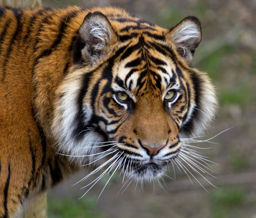

In [3]:
from fastdownload import download_url
dest = 'tiger.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

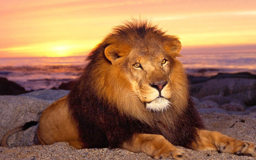

In [4]:
download_url(search_images('lion photos', max_images=1)[0], 'lion.jpg', show_progress=False)
Image.open('lion.jpg').to_thumb(256,256)

In [5]:
searches = 'lion','tiger'
path = Path('lion_or_tiger')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/lib/python3/dist-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Step 2: Training the model

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

26

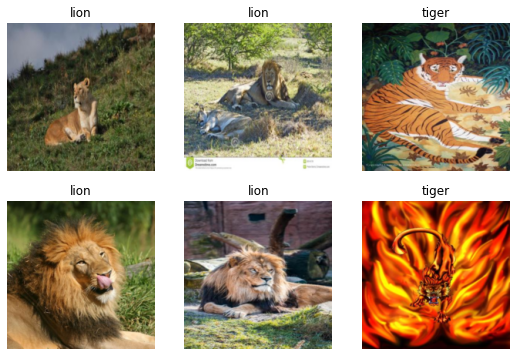

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.439170,0.162055,0.051724,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.122143,0.112009,0.034483,00:02
1,0.066326,0.094499,0.014778,00:02
2,0.039480,0.150047,0.014778,00:02
3,0.023812,0.126668,0.014778,00:02
4,0.014862,0.128445,0.014778,00:02


Check for example image from the dataset:

In [10]:
is_lion,_,probs = learn.predict(Image.open(get_image_files(path)[0]).to_thumb(256,256))
print(f"This is a: {is_lion}.")
print(f"Probability it's a tiger: {probs[0]:.4f}") # should have been "lion" here

This is a: lion.
Probability it's a tiger: 1.0000


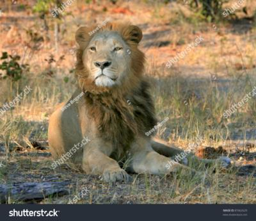

In [11]:
Image.open(get_image_files(path)[0]).to_thumb(256,256)

## Save Model

In [12]:
learn.export('tiger-lion-classifier.pkl')

### Check out the fast.ai website for information about their courses and the fastai library.

https://www.fast.ai/

and the Course Notebook, this notebook is based on:

https://github.com/fastai/course22/blob/master/00-is-it-a-bird-creating-a-model-from-your-own-data.ipynb